Clasificación con la data de la investigación pasada

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

import time
import os
import copy

from PIL import Image
import matplotlib.pyplot as plt
plt.ion()

In [ ]:
import shutil

#if os.path.exists('/content/data/pre/nonsegmentedv2'):
#  shutil.rmtree('/content/data/pre/nonsegmentedv2')
#if os.path.exists('/content/drive/My Drive/Carnes_Clau'):
#  shutil.rmtree('/content/drive/My Drive/Carnes_Clau')

def get_file_list_from_dir(datadir):
    all_files = os.listdir(os.path.abspath(datadir))
    data_files = list(filter(lambda file: file.endswith('.jpeg'), all_files))
    return data_files

subfolders = [ f.name for f in os.scandir('/content/drive/My Drive/Carnes_Clau') if f.is_dir() ]
subfolders

train = 0.75
val = 0.25
for i in range(len(subfolders)):
  datadirectory = '/content/drive/My Drive/Carnes_Clau/'
  directory = datadirectory + subfolders[i]
  datadirtrain = '/content/data/train/' + subfolders[i]
  datadirval = '/content/data/val/' + subfolders[i]
  
  if not os.path.exists(datadirtrain):
    os.makedirs(datadirtrain)
  if not os.path.exists(datadirval):
    os.makedirs(datadirval)

  filelist = get_file_list_from_dir(directory)
  trainnum = len(filelist) * train
  valnum = len(filelist) - trainnum

  for j in range(len(filelist)):
    if(j < trainnum):
      aux1 = datadirtrain
      aux2 = filelist[j]
    if(j >= trainnum):
      aux1 = datadirval
      aux2 = filelist[j]
    
    shutil.move((directory + '/' + aux2), (aux1 + '/' + aux2))

In [ ]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



data_dir = '/content/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

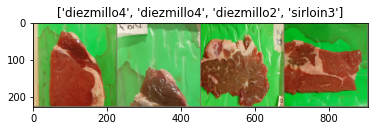

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 12.
model_ft.fc = nn.Linear(num_ftrs, 12)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4353 Acc: 0.1833
val Loss: 1.9304 Acc: 0.3000

Epoch 1/24
----------
train Loss: 1.8344 Acc: 0.3667
val Loss: 1.3364 Acc: 0.7000

Epoch 2/24
----------
train Loss: 1.5408 Acc: 0.5000
val Loss: 1.1695 Acc: 0.6500

Epoch 3/24
----------
train Loss: 1.2978 Acc: 0.6167
val Loss: 0.8418 Acc: 0.6000

Epoch 4/24
----------
train Loss: 1.0521 Acc: 0.6667
val Loss: 0.5283 Acc: 0.9500

Epoch 5/24
----------
train Loss: 0.8083 Acc: 0.7167
val Loss: 0.5448 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.8229 Acc: 0.7833
val Loss: 0.4329 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.6373 Acc: 0.8500
val Loss: 0.3988 Acc: 0.9500

Epoch 8/24
----------
train Loss: 0.6653 Acc: 0.8167
val Loss: 0.3328 Acc: 0.9500

Epoch 9/24
----------
train Loss: 0.4789 Acc: 0.9333
val Loss: 0.3021 Acc: 0.9500

Epoch 10/24
----------
train Loss: 0.4280 Acc: 0.9333
val Loss: 0.2868 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.5008 Acc: 0.8833
val Loss: 0.2815 Acc: 1.0000

Ep

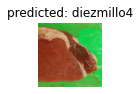

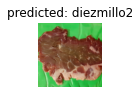

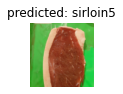

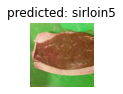

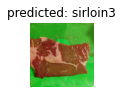

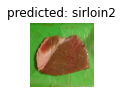

In [ ]:
visualize_model(model_ft)